# Kaggle Titanic Competition
###Karen Xiao

5/6/2015

##Loading in Data
First, we will read in the data file `titanic.csv` and store it as a Numpy array. We will be using the `csv` package to read and write csv files and the `Numpy` package for some of its array and other functions.

In [220]:
import csv as csv 
import numpy as np

raw_csv = csv.reader(open('train.csv', 'rb')) 

# skip the header
header = raw_csv.next()

# read in rows from the raw_csv file and store in data variable         
data=[]                        
for row in raw_csv:     
    data.append(row)       
data = np.array(data) 

print header
print data[0]

['survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'pclass', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest']
['1' 'Allen, Miss. Elisabeth Walton' 'female' '29' '0' '0' '1' '24160'
 '211.3375' 'B5' 'S' '2' '' 'St Louis, MO']


##Plotting the Data
Now that we have the data loaded in, we can plot some initial data just to get a sense of what we have. Here we will use a plotting library called `Matplotlib`. As a first hypothesis, we might look at the survival chances based on gender. 

Percentage of women who survived: 0.742038216561
Percentage of men who survived: 0.188908145581


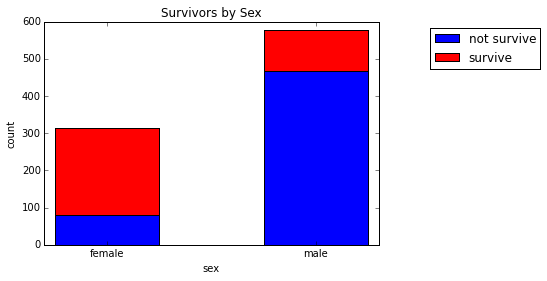

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# define "mask" variables that can be applied on the data to filter on females in column 4
female_mask = data[0::,4] == "female"
male_mask = data[0::,4] != "female"

women = data[female_mask,1].astype(np.float)     
men = data[male_mask,1].astype(np.float)

# calculate percentages
print "Percentage of women who survived: %s" % (np.sum(women) / np.size(women))
print "Percentage of men who survived: %s" % (np.sum(men) / np.size(men))

# plot the data
width = .5
index = np.arange(2) + .25
survived = [np.sum(women), np.sum(men)]
died = [np.size(women) - np.sum(women), np.size(men) - np.sum(men)] 

plot_died = plt.bar(index, died, width, color='b')
plot_survived = plt.bar(index, survived, width, color='r', bottom=died)   

plt.title('Survivors by Sex')
plt.ylabel('count')
plt.xlabel('sex')
plt.xticks(index+.25, ['female', 'male'])
plt.legend((plot_died, plot_survived), ('not survive', 'survive'), bbox_to_anchor=(1.5, 1))

plt.show()

##A Simple Gender-based Model
Now that we've looked at this dimension of the data, we can create a very basic model to predict whether a passenger will survive purely based off of their gender. Clearly, this model is not going to give us the best results, but it works as an initial exercise.

The code below will read in the data, apply our model, and output our prediction to a csv file in a format ready for submission to Kaggle. Unlike before, instead of using a Numpy array to store and manipulate our data, we will be using a Pandas DataFrame, which has some more sophisticated capabilities. 

In [147]:
import pandas as pd

# read in the data using the Pandas .read_csv function
raw_data = pd.read_csv('train.csv', header=0)

# create prediction DataFrame with 'Survived' set to 1 if the passenger is female
predictions = pd.DataFrame({'PassengerId': raw_data.PassengerId, 'Survived': raw_data.Sex.map({'female': 1, 'male': 0})})

# write the resulting predictions to a csv file
predictions.to_csv('genderpredictions.csv', index=False)

##Cleaning the Data
At this point, we probably want to do something a little more complex and use more than just one paramter to make our predictions. However, taking a closer look at our data reveals a few gaps. Notice when we run the `df.info()` command, we find that `Age, Fare,` and `Cabin` are missing some values:

In [149]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


The decision now is what to fill the missing data with. We obviously don't want to just guess or fill it with random values because that will introduce a lot of noise into our data. Other common options are to fill the gaps with the mean or median values of that parameter. But we're going to get a little fancier. 

To fill in the missing `Age` data, we're going to find the age typical to each gender and passenger class using a 2 x 3 reference table (for 2 genders and 3 passenger classes). For `Fares`, we might expect the median fare to be fairly closely correlated with the passenger class, so we calculate the median fares for each class and fill in the data appropriately. Below we have written a function to do this:

In [184]:
"""
Function
--------
clean_missing_data

Given a DataFrame, fill in the missing Age and Fare data with median values

Inputs
------
df : DataFrame
    The DataFrame object read in from the Kaggle Titanic train and test csv files
"""    

def clean_missing_data(df):

    # ceate new column converting Sex (female, male) stored as strings to Gender (0, 1) stored as ints
    df['Gender'] = df.Sex.map({'female': 0, 'male': 1}).astype(int)

    # create our reference table for median ages based on passenger class and gender
    median_ages = np.zeros((2, 3))
    for i in range(2):
        for j in range(3):
            median_ages[i, j] = df[(df.Gender == i) & (df.Pclass == j+1)]['Age'].dropna().median()

    # fill in null values
    for index, row in df[df['Age'].isnull()].iterrows():
        df.loc[index,'Age'] = median_ages[row.Gender][row.Pclass-1]

    # calculate median fares for each passenger class
    median_fares = np.zeros(3)
    for i in range(3):
        median_fares[i] = df[df.Pclass == i+1]['Fare'].dropna().median()

    # fill in null values
    for index, row in df[df['Fare'].isnull()].iterrows():
        df.loc[index,'Fare'] = median_fares[row.Pclass-1] 
        
    return df

# read in our test and train datasets and store as DataFrames
train_csv = pd.read_csv('train.csv', header=0)
test_csv = pd.read_csv('test.csv', header=0)

# fill in the missing data
train_clean = clean_missing_data(train_csv)
test_clean = clean_missing_data(test_csv)

For the purposes of this exercise, and to more easily use the scikit-learn package, we don't want any non-numeric values. So using the `df.dtypes`, we find that the `Name, Sex, Ticket, Cabin,` and `Embarked` columns are of type object (which means string in Pandas). For now, since we don't need them, we will remove these columns. For the purposes of our next exercise, we will also remove `PassengerId`.

In [185]:
# keep a copy of the passenger ids for later
passenger_ids = test_clean.PassengerId.values

# drop unneeded (non-numerical) columns
train_clean = train_clean.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1) 
test_clean = test_clean.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1) 

Now we have a nice and clean dataset! The last step is to convert this to a Numpy array so it is consummable by `sklearn`

In [219]:
# convert to Numpy array
train_data = train_clean.values
test_data = test_clean.values

# print out the result
train_data.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

Now that we have a clean data set that's in a consummable Numpy array format, we can start running it against some models.

##Logistic Regression
Logistic regression usually works well for binary classifications. In this case, we are predicting if a passenger survived or didn't survive, so logistic regression is probably a good one to start with.

In [207]:
from sklearn.linear_model import LogisticRegression 

# create the logistic regression object which will include all the parameters for the fit
regression = LogisticRegression()

# fit the training data to the Survived labels 
regression = regression.fit(train_data[0::,1::],train_data[0::,0])

# run on the test data
predictions = regression.predict(test_data)

# format to be submittable to Kaggle and write out to csv
predictions_file = open("regressionpredictions.csv", "wb")
file_writer = csv.writer(predictions_file)
file_writer.writerow(["PassengerId","Survived"])
file_writer.writerows(zip(passenger_ids, predictions.astype(int)))
predictions_file.close()

##Decision Trees
Decision trees are also simple and tend to work well with classification problems, so we might also try a decision tree implementation.

In [218]:
from sklearn import tree

classifier = tree.DecisionTreeClassifier()
classifier = classifier.fit(train_data[0::,1::],train_data[0::,0])
predictions = classifier.predict(test_data)

# format to be submittable to Kaggle and write out to csv
predictions_file = open("treepredictions.csv", "wb")
file_writer = csv.writer(predictions_file)
file_writer.writerow(["PassengerId","Survived"])
file_writer.writerows(zip(passenger_ids, predictions.astype(int)))
predictions_file.close()

# plot the tree created
from sklearn.externals.six import StringIO
with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(classifier, out_file=f)
# then in the terminal, run "dot -Tpng tree.dot -o tree.png"

##Random Forest
Decision trees don't always work well with certain datasets because they can overfit to the training set, so we might use an ensemble learning method like random forests that create many different decision trees and predict the result based on the results of the individual trees. 

In [201]:
from sklearn.ensemble import RandomForestClassifier 

forest = RandomForestClassifier(n_estimators = 100)
forest = forest.fit(train_data[0::,1::],train_data[0::,0])
predictions = forest.predict(test_data)

# format to be submittable to Kaggle and write out to csv
predictions_file = open("forestpredictions.csv", "wb")
file_writer = csv.writer(predictions_file)
file_writer.writerow(["PassengerId","Survived"])
file_writer.writerows(zip(passenger_ids, predictions.astype(int)))
predictions_file.close()